# main_slim

This is the main Jupyter notebook used to explore the use of STP in identifying novel proteins associated to NAFLD, using the slim_list.csv as the set of human proteins associated with NAFLD. This notebook contains the relevant explanations and justifications for the approaches taken to identify new proteins associated with NAFLD.

## References

1. Yoon, S.-B.; Ma, Y.-C. ; Venkat, A.; Liu, C.-Y.; Zheng, J.J. Applying Protein–Protein Interactions and Complex Networks to Identify Novel Genes in Retinitis Pigmentosa Pathogenesis. Int. J. Mol. Sci. 2022, 23, 3962. https://doi.org/10.3390/ijms23073962
2. Ghiassian SD, Menche J, Barabási A-L (2015) A DIseAse MOdule Detection (DIAMOnD) Algorithm Derived from a Systematic Analysis of Connectivity Patterns of Disease Proteins in the Human Interactome. PLoS Comput Biol 11(4): e1004120. https://doi.org/10.1371/journal.pcbi.1004120
3. Menche, J.; Sharma, A.; Kitsak, M.; Ghiassian, S.D.; Vidal, M.; Loscalzo, J.; Barabasi, A.-L. Uncovering Disease-Disease Relationships through the Incomplete Interactome. Science 2015, 347, 1257601.
4. Cristian Riveros, Jorge Salas, and Oskar Skibski. 2018. How to choose the root: centrality measures over tree structures. In Proceedings of Woodstock ’18: ACM Symposium on Neural Gaze Detection (Woodstock ’18). ACM, New York, NY, USA, 14 pages. https://doi.org/10.1145/1122445.1122456

In [1]:
import networkx as nx
import numpy as np
import pandas as pd

In [4]:
# Reading in graph 
G = nx.read_weighted_edgelist("data/yeast.txt",comments="#",nodetype=str)

In [5]:
# Deleting edges that don't meet threshold score
threshold_score = 700
for edge in G.edges: 
  weight = list(G.get_edge_data(edge[0],edge[1]).values())
  if(weight[0] <= threshold_score):
    G.remove_edge(edge[0],edge[1])

# Relabelling nodes to remove "4932." tag
G = nx.relabel_nodes(G, lambda x: x[5:])

In [6]:
# Consider only the giant component
GC = G.subgraph(max(nx.connected_components(G), key=len)).copy()

We use the yeast homolog csv file generated in the human_to_yeast folder to load our list of yeast homologs to human proteins associated with NAFLD. 

In [7]:
# Getting list of all yeast homologs
df = pd.read_csv("human_to_yeast/human_to_yeast.csv")

# Note: some homologs in this list may also be present in the essential nodes list, so they wont be included in the subgraph.
homologs = list(set(list(df["homolog_systematic_name"])))

print(f"Number of yeast homologs: {len(homologs)}")

Number of yeast homologs: 218


If we were to induce the subgraph of all NAFLD nodes, is it connected?

In [8]:
NAFLD = GC.subgraph(homologs).copy()
print(nx.is_connected(NAFLD))

False


We check the nature of the unconnectedness of NAFLD nodes.

In [9]:
print(f"{len(list(nx.isolates(NAFLD)))} isolated nodes (degree 0): {list(nx.isolates(NAFLD))}")

connected_components = [nodes for nodes in sorted(nx.connected_components(NAFLD), key=len, reverse=True)]

print(f"Sizes of connected components: {list(map(len, connected_components))}")

# List containing NAFLD nodes not connected to the giant component
unconnected = []
for cc in connected_components[1:]:
  unconnected.extend(cc)

print(f"Number of unconnected nodes: {len(unconnected)}")

50 isolated nodes (degree 0): ['YKR026C', 'YPL088W', 'YKL179C', 'YKL198C', 'YLL019C', 'YKL029C', 'YHR190W', 'YHL023C', 'YBR041W', 'YML098W', 'YNR050C', 'YIL048W', 'YBL071W-A', 'YGL104C', 'YHR057C', 'YDR221W', 'YPR047W', 'YMR038C', 'YJR001W', 'YIL043C', 'YNL123W', 'YBR233W', 'YGL220W', 'YBR288C', 'YDR424C', 'YLR025W', 'YOR085W', 'YML027W', 'YOR306C', 'YPR192W', 'YBR236C', 'YDL114W', 'YOL119C', 'YIR027C', 'YBR139W', 'YPR003C', 'YOR344C', 'YHR176W', 'YOR323C', 'YHR002W', 'YDL112W', 'YKR019C', 'YNL026W', 'YCR026C', 'YNL023C', 'YBR187W', 'YJL179W', 'YLR247C', 'YBR241C', 'YCL057W']
Sizes of connected components: [147, 4, 3, 3, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Number of unconnected nodes: 70


We now act under the hypothesis that NAFLD-related nodes are likely to interact with one another through PPI. The idea that disease-related nodes are highly likely to be connected more often than non-disease nodes, and that disease-related nodes have distinct interactions with one another is a well-documented and supported phenomenon [2, 3]. 

Despite the evidenced backing for the hypothesis, we also run some of our own analysis specific to NAFLD. We take the list of human proteins associated with NAFLD in data/human.txt, pass it as input to [STRING](https://string-db.org/cgi/network?taskId=be7BKPBkiU0G&sessionId=bOXRLD1COgLC) giving us the subgraph induced by the human NAFLD proteins, [download as short tabular text output](https://string-db.org/cgi/generatetaskspecificdownloadfile?taskId=be7BKPBkiU0G&downloadDataFormat=tsv_short&cpnonce=bbPkEH0bBMwS&downloadFileName=string_interactions_short.tsv), saving the file as 'human_NAFLD.tsv', and then have a look at the connected components.

In [11]:
# Reading in tab separated values for network downloaded from STRING
human_NAFLD = pd.read_csv("data/human_NAFLD.tsv", sep = "\t")
df = human_NAFLD[['#node1', 'node2', 'combined_score']]

# To bring confidence values back to required range
df['combined_score'] = df['combined_score'].multiply(1000)

# Converting back to required form for networkx to be able to read in graph
df.to_csv("data/human_NAFLD.txt", sep=" ", header=None, index=None)

H = nx.read_weighted_edgelist("data/human_NAFLD.txt",comments="#",nodetype=str)

# Deleting edges that don't meet threshold score
threshold_score = 700
for edge in H.edges: 
  weight = list(H.get_edge_data(edge[0],edge[1]).values())
  if(weight[0] <= threshold_score):
    H.remove_edge(edge[0],edge[1])


H_connected_components = [nodes for nodes in sorted(nx.connected_components(H), key=len, reverse=True)]
print(f"Sizes of connected components: {list(map(len, H_connected_components))}")

Sizes of connected components: [385, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


C:\Users\amool\AppData\Local\Temp\ipykernel_11696\566239666.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['combined_score'] = df['combined_score'].multiply(1000)


It is clear that large majority of human proteins associated with NAFLD are connected. It could also be the case that many of these isolated nodes come about as a consequence of incomplete Interactome and gene-disease association data [2].

With this understanding in mind, if NAFLD-related nodes are highly likely to be connected, then it is likely that there are 'intermediate' nodes facilitating the connection of unconnected nodes [1]. We consider these nodes as our candidate nodes for the discovery of novel proteins associated with NAFLD [1]. To find these intermediate nodes, we introduce the Steiner Tree Problem (STP).

## Steiner Tree Problem

The [Steiner Tree Problem in graphs](https://en.wikipedia.org/wiki/Steiner_tree_problem) (STP) is the following: given an undirected graph $G(V, E)$ with non-negative edge weights and a subset $T \subseteq V$ of vertices referred to as terminals, the solution to the Steiner Tree Problem in graphs is a tree of minimum weight that spans all terminal vertices. In the general case it is an NP-hard problem. 

NetworkX has an approximation algorithm to STP that is painfully, painfully slow even on small instances, does not return optimal solutions (sometimes fairly far off) and does not allow for other types of STP, such as node-weights or prize-collecting variations of the problem. This led me to consider using other implementations to solve the problem. I could not find any Python implementations (which is understandable, given that Python is not the programmer's choice for optimising performance), but found [SCIP-Jack](https://scipjack.zib.de/), an very modern (2021) implementation in C that had remarkable performance. Unfortunately, Windows was not compliant with the process of building executables, so SCIP-Jack was downloaded, built and run in Linux using WSL (instructions and other info can be found in the README). 

We consider STP where our graph is the giant component `GC` of the full yeast network, our terminals are the set of NAFLD-related nodes `NAFLD` and our edges are of the same weight (in this case we set it to unit weight). This returns a minimum spanning tree that spans all NAFLD nodes. In the presence of unconnected NAFLD nodes, such a tree would have to include non-NAFLD nodes from `GC` to be able to reach them. These non-NAFLD nodes are our candidate nodes. 

In [12]:
# Create separate graph where all edge weights are 1.
GC1 = GC.copy()
for (u, v, d) in GC1.edges().data():
  d['weight'] = 1

In [13]:
# Obtain list of all NAFLD nodes present in GC1
NAFLD_nodes = []
for node in GC1.nodes():
  if node in homologs:
    NAFLD_nodes.append(node)

In [17]:
import stp

node_to_int = stp.nxgraph_to_stp(graph=GC1, terminals=NAFLD_nodes, filename="NAFLD.stp")

We then use the NAFLD.stp file and SCIP-Jack to solve the STP (instructions in README), producing the NAFLD.stp file containing the optimal solution.

In [18]:
int_to_node = {v: k for k, v in node_to_int.items()}

ST = stp.stplog_to_nxgraph(filename="NAFLD.stplog", int_to_node=int_to_node)

Now, we remove all the NAFLD nodes to leave us with the non-NAFLD nodes for analysis. These nodes are regarded as the "intermediate nodes" that are connecting all our NAFLD nodes to each other.

In [19]:
non_NAFLD = []
for node in ST.nodes():
  if node not in NAFLD_nodes:
    non_NAFLD.append(node)

print(len(non_NAFLD))

39


In [20]:
node_color = []
node_size = []
for node in ST.nodes():
  if node in non_NAFLD:
    node_color.append("orange")
    node_size.append(400)
  elif node in unconnected:
    node_color.append("red")
    node_size.append(100)
  else:
    node_color.append("black")
    node_size.append(1)

edge_color = []
for (u, v) in ST.edges():
  if (u in unconnected and v in unconnected) or (u in unconnected and v in non_NAFLD) or (v in unconnected and u in non_NAFLD) or (v in non_NAFLD and u in non_NAFLD):
    edge_color.append("black")
  else:
    edge_color.append("grey")

labels = {}
for node in non_NAFLD + unconnected:
  labels[node] = node 

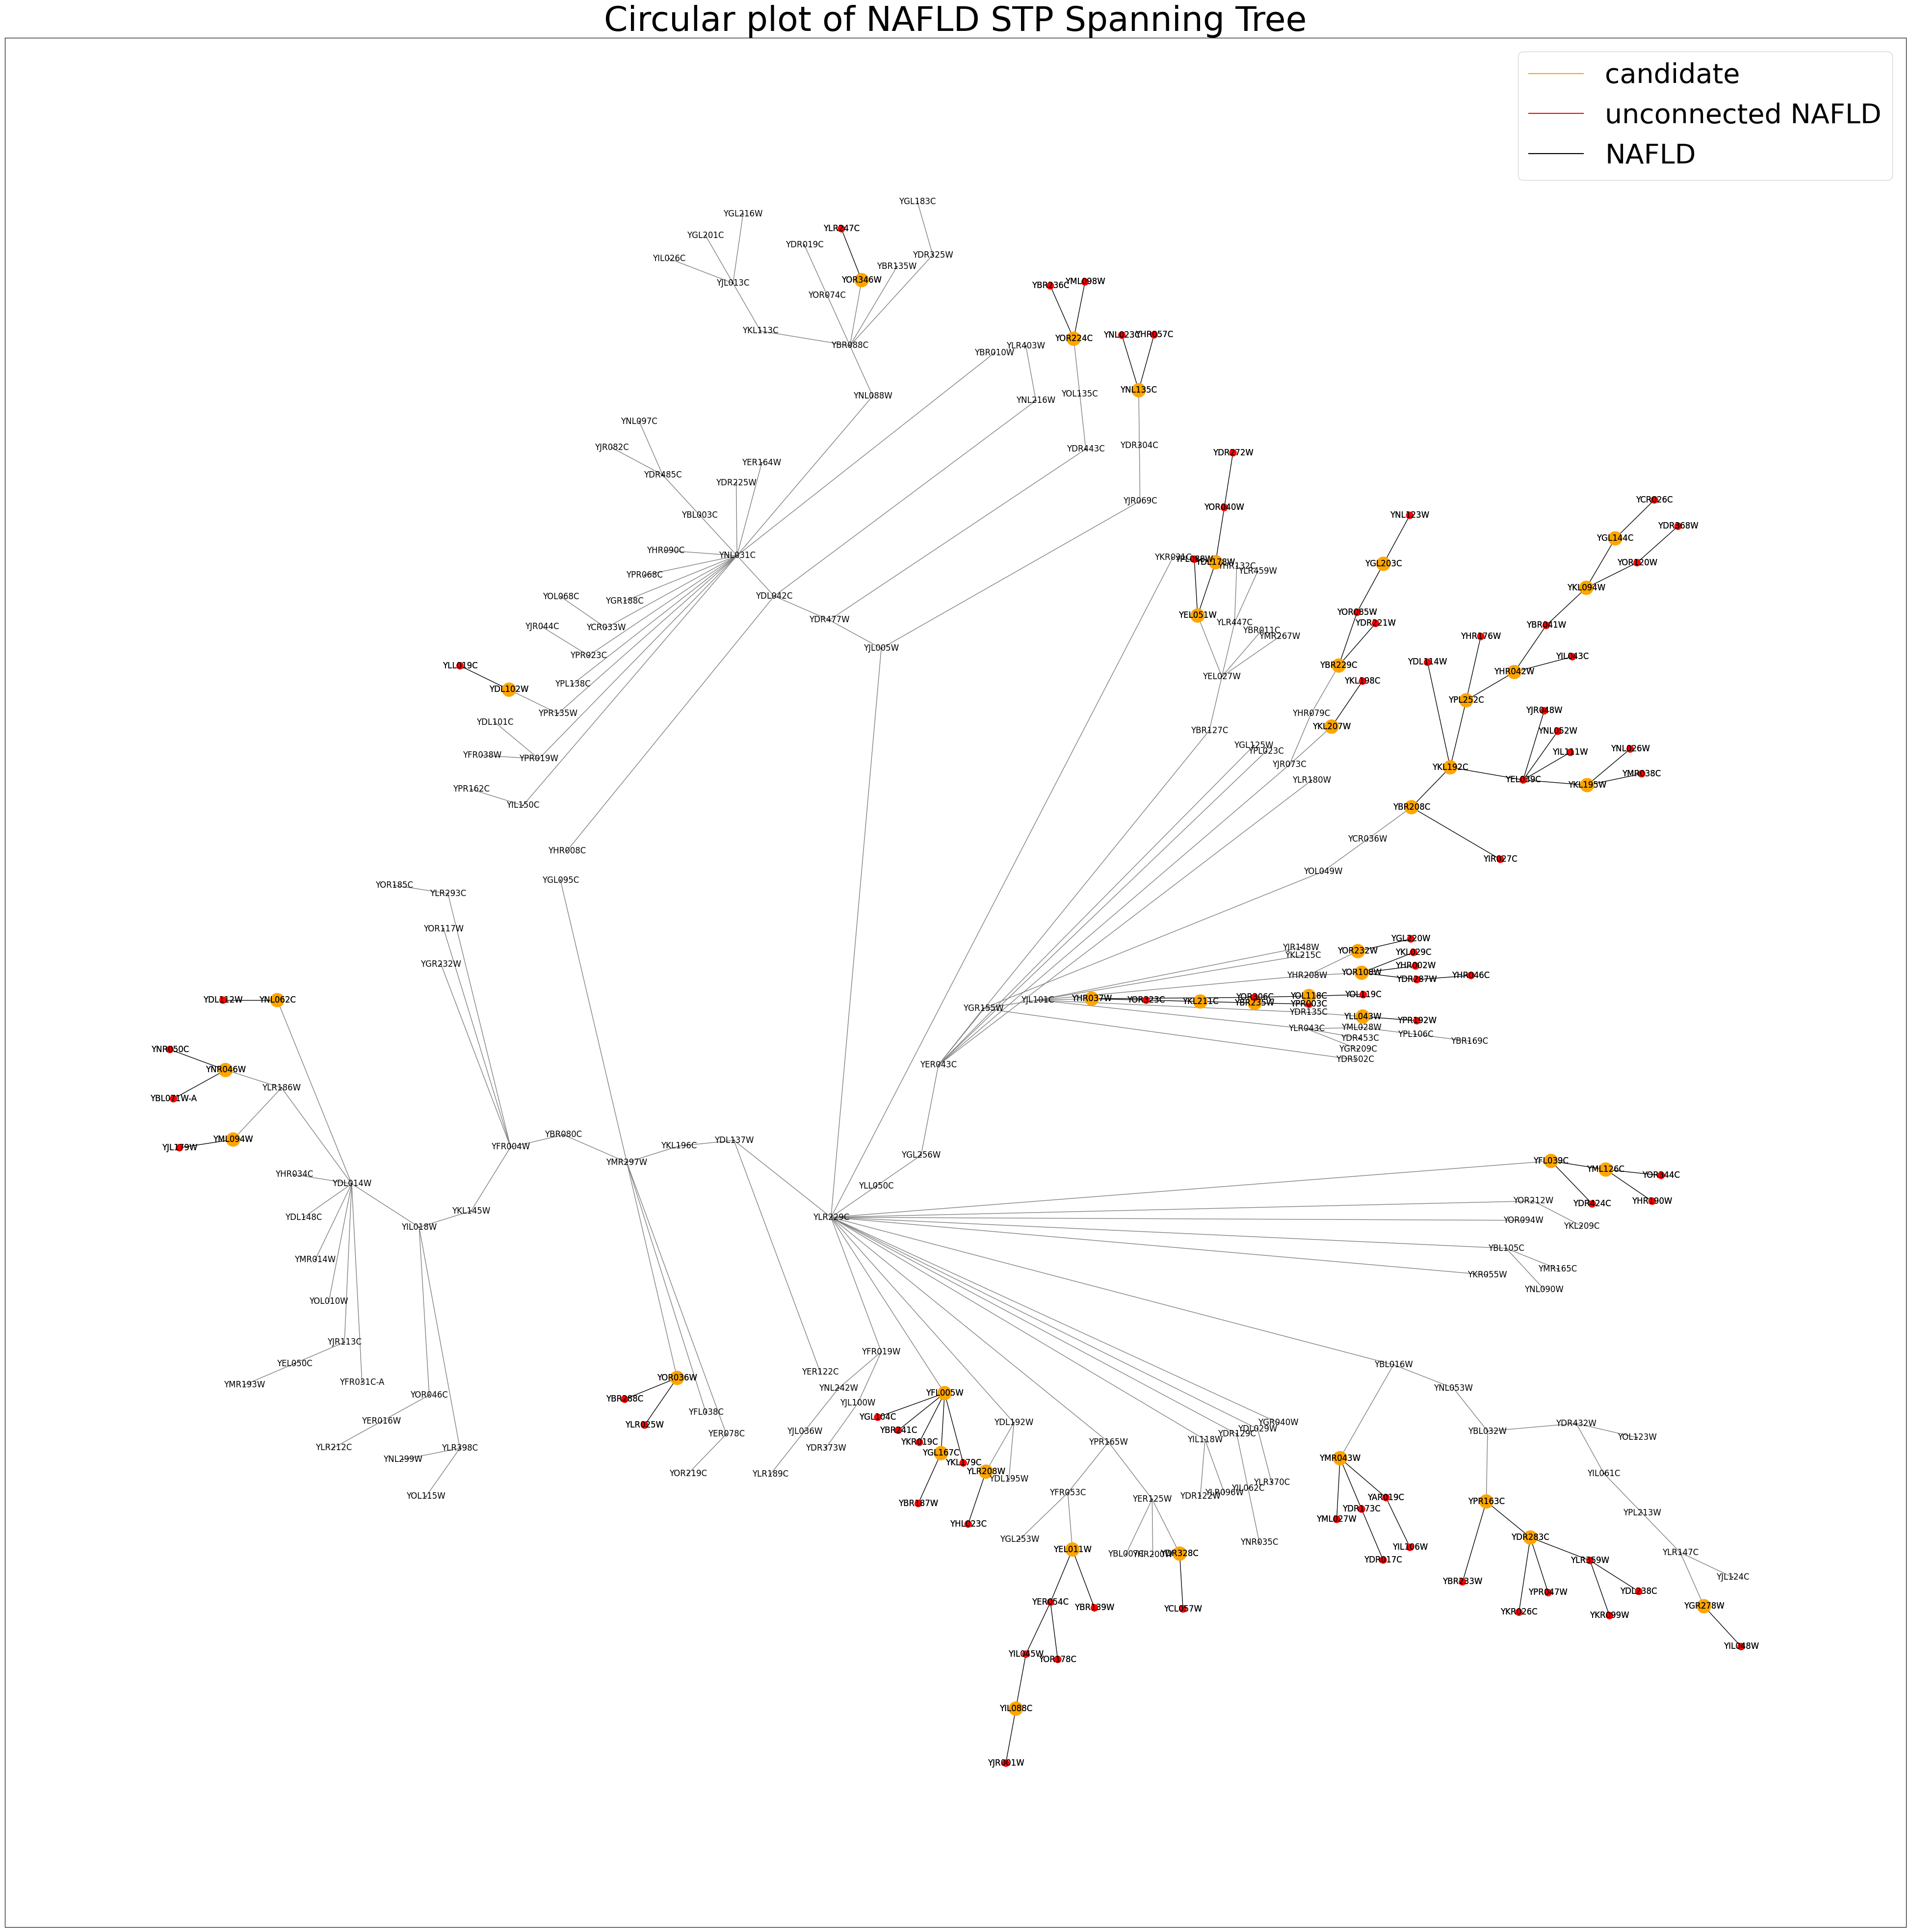

In [21]:
import matplotlib.pyplot as plt
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

T = nx.tree.minimum_spanning_tree(ST)
pos = graphviz_layout(T, prog="twopi")

f = plt.figure(1, figsize=(50,50))
ax = f.add_subplot(1,1,1)
ax.plot([0],[0], color="orange", label="candidate")
ax.plot([0],[0], color="red", label="unconnected NAFLD")
ax.plot([0],[0], color="black", label="NAFLD")

nx.draw_networkx(T, node_color=node_color, node_size=node_size, pos=pos, edge_color=edge_color, ax=ax)
nx.draw_networkx_labels(T, pos, labels=labels, font_size=12)
plt.title("Circular plot of NAFLD STP Spanning Tree", fontdict = {'fontsize' : 50})
plt.legend(prop={'size': 40})
plt.show()

From here, we aim to narrow down this list of intermediate nodes to some quality candidate nodes for experiments. We first check if any of the candidate nodes are essential before analysing them further. We remove these nodes from contention.

In [23]:
df = pd.read_csv("data/essential_proteins.csv", header=None)
essential_proteins = df[1].values

essential_candidates = [node for node in non_NAFLD if node in essential_proteins]
candidates = [node for node in non_NAFLD if node not in essential_proteins]

print(f"List of candidate nodes after removing essential nodes: {candidates}")

List of candidate nodes after removing essential nodes: ['YKL211C', 'YOR346W', 'YEL051W', 'YBR208C', 'YEL011W', 'YKL094W', 'YDR283C', 'YGL167C', 'YPR163C', 'YDL178W', 'YML094W', 'YNL135C', 'YGL203C', 'YBR229C', 'YKL207W', 'YOR108W', 'YLL043W', 'YBR235W', 'YHR037W', 'YGL144C', 'YIL088C', 'YOL118C']


We also slim the candidates list down to nodes which have human homologs using the YeastMine API, since the end goal would be to run experiments using human cells.

In [24]:
from intermine.webservice import Service
service = Service("https://yeastmine.yeastgenome.org/yeastmine/service")

template = service.get_template('Gene_OMIM_Disease')

s = ",".join(candidates)

rows = template.rows(
    A = {"op": "LOOKUP", "value": s, "extra_value": ""}
)

df = pd.DataFrame(rows)

In [25]:
candidates = list(set(df[1]))
print(f"List of candidate nodes after nodes with no human homologs: {candidates}")

List of candidate nodes after nodes with no human homologs: ['YML094W', 'YKL094W', 'YNL135C', 'YDR283C', 'YDL178W', 'YHR037W', 'YOR346W', 'YBR208C', 'YGL167C', 'YBR229C', 'YEL011W', 'YLL043W', 'YEL051W']


# Analysis of Candidates

To analyse which of the remaining candidate nodes are best, we run various centrality and importance measures.

## Centrality Measures on Trees

The classic measure of the centrality of a node in a tree is how well it is suited to rooting the tree. For example, a very commonly used notion of a tree's center is denoted the Graph Center (Jordan Center in trees), which is the set of vertices that minimises the maximal distance to other points in the tree (eccentricity). [4] proposes the property of "rooting trees" where a measure selects one or two nodes (in the case of equality) as the most important nodes and importance decreases from them in all directions (i.e. every child node has a lower importance). Under this framework, the paper identifies eccentricity as a metric which achieve this property. 

## Number of Unconnected Nodes in Subtree

We now consider a separate measure: if we root the undirected tree at the center determined by eccentricity and run Depth-First Search from the root to find the directed tree, what is the number of unconnected nodes that have been connected by a candidate node (in other words, the number of unconnected nodes in the subtree rooted at the candidate)? A candidate node that is able to connect more unconnected nodes in our spanning tree is desirable, as it is acting as an intermediate node for many interactions.

In [26]:
ec_center = nx.center(ST)
print(f"Centers given by eccentricity: {ec_center}")

Centers given by eccentricity: ['YGL256W', 'YLL050C']


These nodes are all adjacent to each other (see spanning tree plot). Moreso, regardless of what center we take, it will not affect the subtree size since none of these nodes are all known NAFLD nodes. W.L.O.G we choose 'YGL256W' as our center. 

In [27]:
dfs = nx.algorithms.traversal.dfs_tree(ST, source='YGL256W')

sc = []
for candidate in candidates:
  unconnected_in_subtree = [unconnected for node in nx.algorithms.traversal.dfs_preorder_nodes(dfs, source=candidate) if node in unconnected]
  sc.append((candidate, len(unconnected_in_subtree)))

sc.sort(key=lambda x:x[1], reverse=True)

## Graph Centralities

We now analyse the original NAFLD graph, but now with one of our remaining candidate nodes included, and calculate degree, eigenvector, closeness, betweenness and subgraph centralities on each of the candidates. This will give us an indication of how well connected the candidate nodes are to other known NAFLD nodes.

In [28]:
degree_c = []
eigenvector_c = []
closeness_c = []
betweenness_c = []
subgraph_c = []

for candidate in candidates:
  H = GC1.subgraph(NAFLD_nodes + [candidate])
  degree_c.append((candidate, nx.degree_centrality(H)[candidate]))
  eigenvector_c.append((candidate, nx.eigenvector_centrality(H)[candidate]))
  closeness_c.append((candidate, nx.closeness_centrality(H)[candidate]))
  betweenness_c.append((candidate, nx.betweenness_centrality(H)[candidate]))
  subgraph_c.append((candidate, nx.subgraph_centrality(H)[candidate]))

degree_c.sort(key=lambda x:x[1], reverse=True)
eigenvector_c.sort(key=lambda x:x[1], reverse=True)
closeness_c.sort(key=lambda x:x[1], reverse=True)
betweenness_c.sort(key=lambda x:x[1], reverse=True)
subgraph_c.sort(key=lambda x:x[1], reverse=True)

We now create a table containing the rankings of each candidate in each measure (out of personal intrigue).

In [29]:
graph_centrality = pd.DataFrame(columns=['degree', 'eigenvector', 'closeness', 'betweenness', 'subgraph'])
graph_centrality['degree'] = [candidate for (candidate, val) in degree_c]
graph_centrality['eigenvector'] = [candidate for (candidate, val) in eigenvector_c]
graph_centrality['closeness'] = [candidate for (candidate, val) in closeness_c]
graph_centrality['betweenness'] = [candidate for (candidate, val) in betweenness_c]
graph_centrality['subgraph'] = [candidate for (candidate, val) in subgraph_c]
print(graph_centrality)

num = pd.DataFrame(columns=['num_unconnected in subtree'])
num['num_unconnected in subtree'] = [candidate for (candidate, val) in sc]
print(num)

     degree eigenvector closeness betweenness subgraph
0   YEL011W     YOR346W   YEL051W     YEL011W  YOR346W
1   YHR037W     YHR037W   YHR037W     YHR037W  YHR037W
2   YEL051W     YEL051W   YOR346W     YNL135C  YEL011W
3   YNL135C     YEL011W   YEL011W     YBR229C  YEL051W
4   YDR283C     YML094W   YML094W     YML094W  YDL178W
5   YDL178W     YLL043W   YBR229C     YOR346W  YDR283C
6   YOR346W     YBR208C   YLL043W     YBR208C  YBR229C
7   YBR229C     YBR229C   YNL135C     YLL043W  YNL135C
8   YML094W     YNL135C   YBR208C     YEL051W  YML094W
9   YKL094W     YDL178W   YDR283C     YDR283C  YBR208C
10  YBR208C     YDR283C   YDL178W     YKL094W  YLL043W
11  YLL043W     YKL094W   YKL094W     YDL178W  YKL094W
12  YGL167C     YGL167C   YGL167C     YGL167C  YGL167C
   num_unconnected in subtree
0                     YBR208C
1                     YDR283C
2                     YEL011W
3                     YHR037W
4                     YKL094W
5                     YBR229C
6                   

We now normalise each measure and create a grouped bar graph for both graph and tree centralities to better visualise which are the most central candidate proteins.

In [30]:
# takes in sorted (descending order) list containing (node, centrality_value) pairs and returns dictionary
def normalise(c):
  x_max = max(c, key=lambda x:x[1])[1]
  x_min = min(c, key=lambda x:x[1])[1]

  new_d = {node: (val - x_min)/(x_max - x_min) for (node, val) in c}
  return new_d

n_degree_c = normalise(degree_c)
n_eigenvector_c = normalise(eigenvector_c)
n_closeness_c = normalise(closeness_c)
n_betweenness_c = normalise(betweenness_c)
n_subgraph_c = normalise(subgraph_c)

In [31]:
# Choosing an arbitrary series of row names, why not do the candidate proteins in alphabetical order
row_names = [candidate for (candidate, val) in sorted(degree_c)]

# Creating lists containing normalised values, using the order specified in row names
degree = [n_degree_c[candidate] for candidate in row_names]
eigenvector = [n_eigenvector_c[candidate] for candidate in row_names]
closeness = [n_closeness_c[candidate] for candidate in row_names]
betweenness = [n_betweenness_c[candidate] for candidate in row_names]
subgraph = [n_subgraph_c[candidate] for candidate in row_names]

graph = pd.DataFrame(columns = ['degree', 'eigenvector', 'closeness', 'betweenness', 'subgraph'])

graph['degree'] = degree
graph['eigenvector'] = eigenvector
graph['closeness'] = closeness
graph['betweenness'] = betweenness
graph['subgraph'] = subgraph

graph.index = row_names

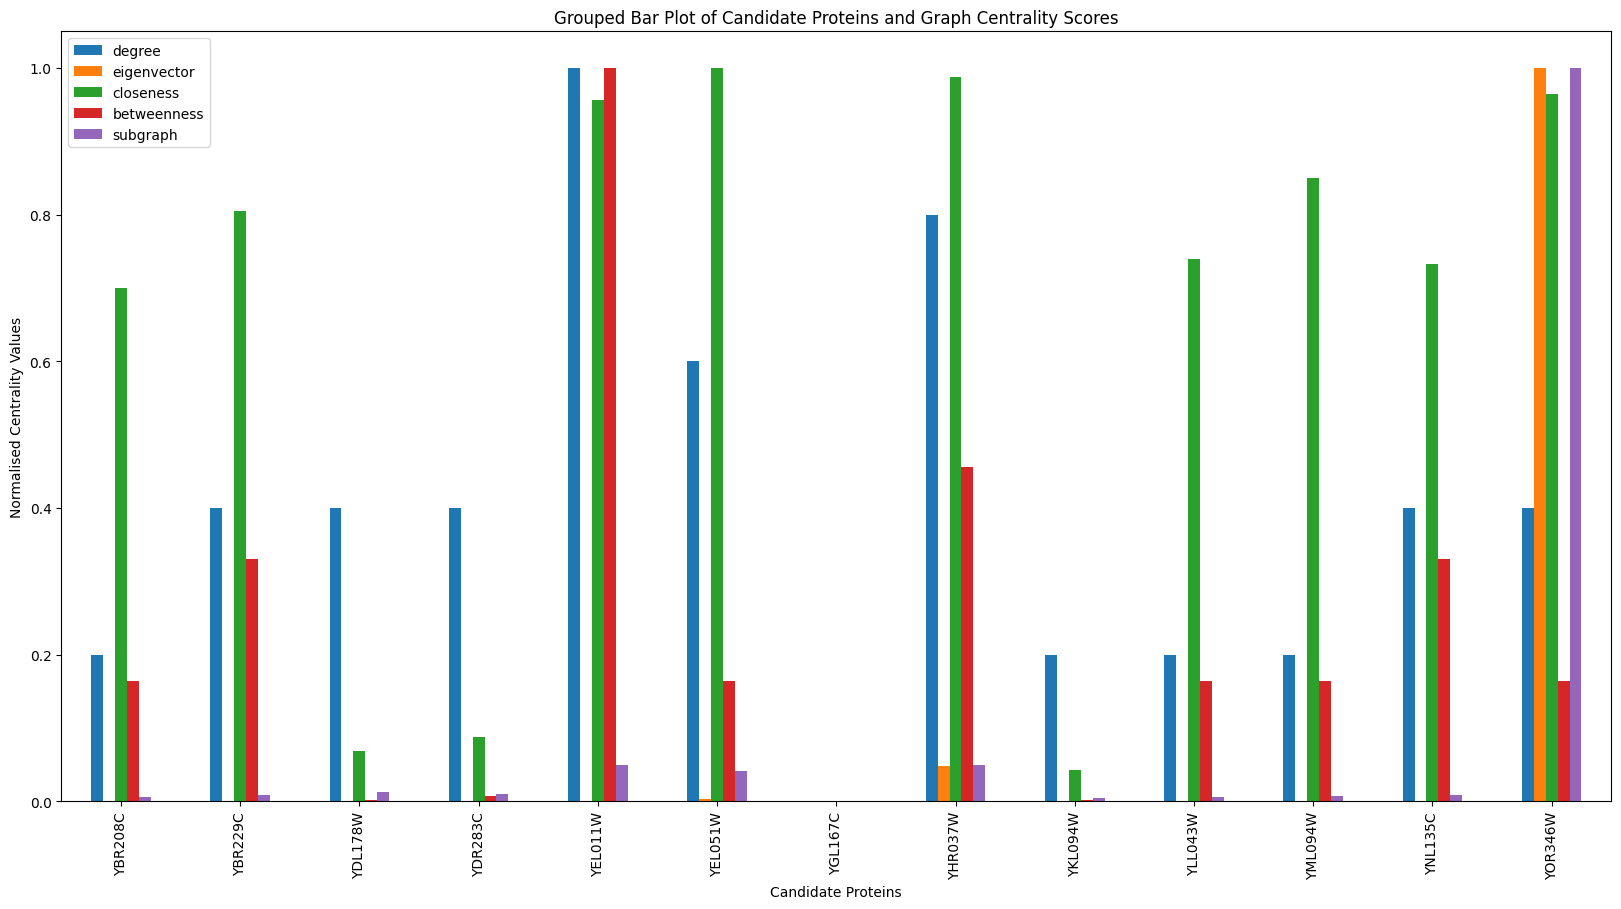

In [32]:
# Plotting grouped bar graph
f = plt.figure(1, figsize=(20,10))
ax = f.add_subplot(1,1,1)
graph.plot(kind='bar', ax = ax)
plt.ylabel("Normalised Centrality Values")
plt.xlabel("Candidate Proteins")
plt.title("Grouped Bar Plot of Candidate Proteins and Graph Centrality Scores")
plt.show()

From the above plot, it is clear that the top performing candidate proteins are 'YOR346W', 'YHR037W', 'YEL011W' and 'YEL051W'.

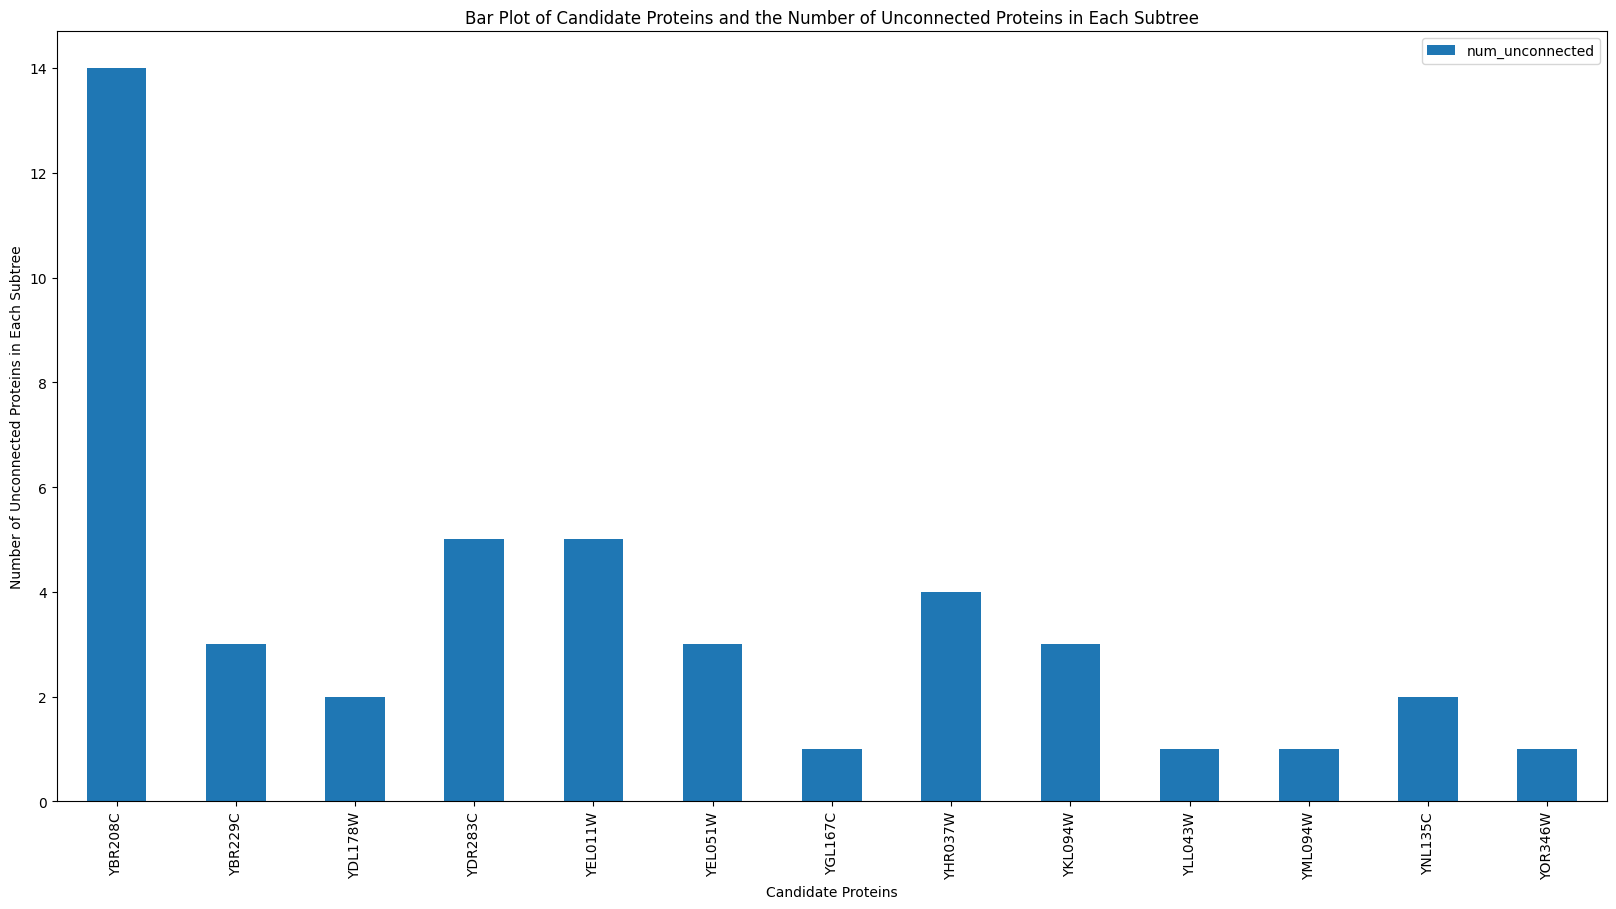

In [33]:
tree = pd.DataFrame(columns = ['num_unconnected'])

tree['num_unconnected'] = [s for (node, s) in sorted(sc)]
tree.index = row_names

# Plotting grouped bar graph
f = plt.figure(1, figsize=(20,10))
ax = f.add_subplot(1,1,1)
tree.plot(kind='bar', ax = ax)
plt.ylabel("Number of Unconnected Proteins in Each Subtree")
plt.xlabel("Candidate Proteins")
plt.title("Bar Plot of Candidate Proteins and the Number of Unconnected Proteins in Each Subtree")
plt.show()

From the above plot, it is clear that 'YBR208C' is an outlier. The graph centrality figures are also not nearly as remarkable for 'YBR208C', which are the measures we are most concerned about when it comes to a candidates connectedness with other known NAFLD proteins. We propose that it might be unfair to associate 'YBR208C' with connecting 14 unconnected NAFLD proteins when it only has direct links with one and is the first in a long chain of candidate proteins in the spanning tree which do connect the other 13. This is not to say that 'YBR208C' is a bad candidate - it is just that using the number of proteins it connects requires further investigation.

There is also nothing remarkable here when it comes to the best performing nodes in graph centralities, with 'YEL011W' being the best performing protein of the four.

# Conclusion

By analysis on network topology, we conclude that 'YOR346W', 'YHR037W', 'YEL011W' and 'YEL051W' are proteins that should be investigated further for possible links to NAFLD.

**Remark:** As it turned out, the biochemists found that "YEL011W" and "YKL094W" in our candidates list were proteins of functional significance to NAFLD. Neither of their human homologs appear in the mega_list.csv file containing the vast set of human proteins associated with NAFLD, indicating that these are novel proteins (as far as the biochemists search for NAFLD-related proteins extends). It is interesting to note that while "YEL011W" has good performance in both metrics above, "YKL094W" does not perform well at all. This supports the idea that topological information is not always enough to determine the strength of a protein's association with a disease, or that the topological measures used are not adequate [2].